"Third" Light
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.2 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.2,<2.3"

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](building_a_system.ipynb) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

Relevant Parameters
-----------------------

**NEW in PHOEBE 2.2**: an `l3_mode` parameter exists for each LC dataset, which determines whether third light will be provided in flux units, or as a fraction of the total flux.

Since this is passband dependent and only used for flux measurments - it does not yet exist for a new empty Bundle.

In [3]:
b.filter(qualifier='l3_mode')

<ParameterSet: EMPTY>

So let's add a LC dataset

In [4]:
b.add_dataset('lc', times=np.linspace(0,1,101), dataset='lc01')

<ParameterSet: 19 parameters | contexts: dataset, compute, constraint>

We now see that the LC dataset created an 'l3_mode' parameter, and since l3_mode is set to 'flux' the 'l3' parameter is also visible.

In [5]:
print(b.filter(qualifier='l3*'))

ParameterSet: 2 parameters
            l3_mode@lc01@dataset: flux
                 l3@lc01@dataset: 0.0 W / m2


## l3_mode = 'flux'

When `l3_mode` is set to 'flux', the `l3` parameter defines (in flux units) how much extraneous light is added to the light curve in that particular passband/dataset.

In [6]:
print(b.filter(qualifier='l3*'))

ParameterSet: 2 parameters
            l3_mode@lc01@dataset: flux
                 l3@lc01@dataset: 0.0 W / m2


In [7]:
print(b.get_parameter('l3'))

Parameter: l3@lc01@dataset
                       Qualifier: l3
                     Description: Third light in flux units
                           Value: 0.0 W / m2
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: l3_mode:flux



To compute the fractional third light from the provided value in flux units, call [b.compute_l3s](../api/phoebe.frontend.bundle.Bundle.compute_l3s).  This assumes that the flux of the system is the sum of the extrinsic passband luminosities (see the [pblum tutorial](./pblum.ipynb) for more details on intrinsic vs extrinsic passband luminosities) divided by $4\pi$ at t0@system, and according to the compute options.

Note that calling `compute_l3s` is not necessary, as the backend will handle the conversion automatically.

In [8]:
print(b.compute_l3s())

{'l3_frac@lc01': 0.0}


## l3_mode = 'fraction'

When `l3_mode` is set to 'fraction', the `l3` parameter is now replaced by an `l3_frac` parameter.

In [9]:
b.set_value('l3_mode', 'fraction')

In [10]:
print(b.filter(qualifier='l3*'))

ParameterSet: 2 parameters
            l3_mode@lc01@dataset: fraction
            l3_frac@lc01@dataset: 0.0


In [11]:
print(b.get_parameter('l3_frac'))

Parameter: l3_frac@lc01@dataset
                       Qualifier: l3_frac
                     Description: Third light as a fraction of total light
                           Value: 0.0
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: l3_mode:fraction



Similarly to above, we can convert to actual flux units (under the same assumptions), by calling [b.compute_l3s](../api/phoebe.frontend.bundle.Bundle.compute_l3s.md).


Note that calling `compute_l3s` is not necessary, as the backend will handle the conversion automatically.

In [12]:
print(b.compute_l3s())

{'l3@lc01': <Quantity 0. W / m2>}


Influence on Light Curves (Fluxes)
-----------------------------------------

"Third" light is simply additional flux added to the light curve from some external source - whether it be crowding from a background object, light from the sky, or an extra component in the system that is unaccounted for in the system hierarchy.

To see this we'll compare a light curve with and without "third" light.

In [13]:
b.run_compute(irrad_method='none', model='no_third_light')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [14]:
b.set_value('l3_mode', 'flux')
b.set_value('l3', 5)

In [15]:
b.run_compute(irrad_method='none', model='with_third_light')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

As expected, adding 5 W/m^3 of third light simply shifts the light curve up by that exact same amount.

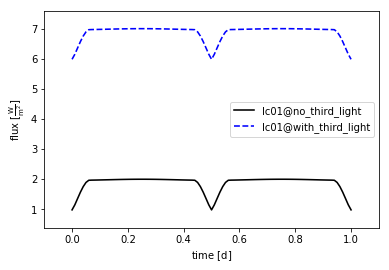

In [16]:
afig, mplfig = b['lc01'].plot(model='no_third_light')
afig, mplfig = b['lc01'].plot(model='with_third_light', legend=True, show=True)

Influence on Meshes (Intensities)
-----------------------------------------

"Third" light does not affect the intensities stored in the mesh (including those in relative units).  In other words, like [distance](distance), "third" light only scales the fluxes.

NOTE: this is different than pblums which **DO** affect the relative intensities.  Again, see the [pblum tutorial](pblum) for more details.

To see this we can run both of our models again and look at the values of the intensities in the mesh.

In [17]:
b.add_dataset('mesh', times=[0], dataset='mesh01', columns=['intensities@lc01', 'abs_intensities@lc01'])

Tue, 25 Jun 2019 11:38 BUNDLE       WARNING mesh dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.


<ParameterSet: 7 parameters | contexts: dataset, compute, constraint>

In [18]:
b.set_value('l3', 0.0)

In [19]:
b.run_compute(irrad_method='none', model='no_third_light', overwrite=True)

Tue, 25 Jun 2019 11:38 BUNDLE       WARNING overwriting model: no_third_light


<ParameterSet: 16 parameters | kinds: mesh, lc>

In [20]:
b.set_value('l3', 5)

In [21]:
b.run_compute(irrad_method='none', model='with_third_light', overwrite=True)

Tue, 25 Jun 2019 11:38 BUNDLE       WARNING overwriting model: with_third_light


<ParameterSet: 16 parameters | kinds: mesh, lc>

In [22]:
print "no_third_light abs_intensities: ", np.nanmean(b.get_value(qualifier='abs_intensities', component='primary', dataset='lc01', model='no_third_light'))
print "with_third_light abs_intensities: ", np.nanmean(b.get_value(qualifier='abs_intensities', component='primary', dataset='lc01', model='with_third_light'))

no_third_light abs_intensities:  27864675903844.145
with_third_light abs_intensities:  27864675903844.145


In [23]:
print "no_third_light intensities: ", np.nanmean(b.get_value(qualifier='intensities', component='primary', dataset='lc01', model='no_third_light'))
print "with_third_light intensities: ", np.nanmean(b.get_value(qualifier='intensities', component='primary', dataset='lc01', model='with_third_light'))

no_third_light intensities:  6.331527425555268e-12
with_third_light intensities:  6.331527425555268e-12
